In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from empiricaldist import Pmf, Cdf

from scipy.stats import shapiro, ttest_ind

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Loading

In [28]:
df_sensors = pd.read_csv('../data/XarxaSoroll_EquipsMonitor_Instal.csv')

noise_2020_1s = pd.read_csv('../data/2020_1S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')
noise_2020_2s = pd.read_csv('../data/2020_2S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')

noise_2021_1s = pd.read_csv('../data/2021_1S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')
noise_2021_2s = pd.read_csv('../data/2021_2S_XarxaSoroll_EqMonitor_Dades_1Hora.csv')

df_2020 = pd.concat([noise_2020_1s, noise_2020_2s])
df_2021 = pd.concat([noise_2021_1s, noise_2021_2s])

filtered_df_2021 = df_2021[df_2021['Id_Instal'].isin(df_2020['Id_Instal'])]
filtered_df_2020 = df_2020[df_2020['Id_Instal'].isin(filtered_df_2021['Id_Instal'])]

noise_2020 = filtered_df_2020['Nivell_LAeq_1h']
noise_2021 = filtered_df_2021['Nivell_LAeq_1h']

df_2020.head()

,Any,Mes,Dia,Hora,Id_Instal,Nivell_LAeq_1h
0,2020,1,1,0:00,4388,72.0
1,2020,1,1,1:00,4388,51.4
2,2020,1,1,2:00,4388,50.2
3,2020,1,1,3:00,4388,50.4
4,2020,1,1,4:00,4388,48.7


In [34]:
df_sensors.head()

,Id_Instal,Codi_Carrer,Tipus_Via,Nom_Carrer,Num_Carrer,Codi_Barri,Nom_Barri,Codi_Districte,Nom_Districte,Latitud,Longitud,ETRS89_X,ETRS89_Y,Data_Instalacio,Data_DesInstalacio,Font
0,186,348408,C,Tuset,8,26,Galvany,5,Sarrià-Sant Gervasi,41.395450,2.152753,429172.441,4583003.592,29/01/2014,16/01/2015,OCI
1,187,348408,C,Tuset,17,26,Galvany,5,Sarrià-Sant Gervasi,41.396156,2.151564,429073.823,4583082.946,29/01/2014,16/01/2015,OCI
2,206,112208,C,Escudellers,53,2,el Barri Gòtic,1,Ciutat Vella,41.380127,2.176924,431177.000,4581283.000,05/02/2014,30/01/2015,OCI
3,207,86902,C,Nou de la Rambla,21,1,el Raval,1,Ciutat Vella,41.378273,2.173348,430876.000,4581080.000,05/02/2014,30/01/2015,OCI
4,208,46409,Pg,Born,19,4,"Sant Pere, Santa Caterina i la Ribera",1,Ciutat Vella,41.384925,2.182772,431671.000,4581811.000,05/02/2014,30/01/2015,OCI


In [46]:
import folium

# Create a Folium map centered on Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=14, tiles="OpenStreetMap")

# Add sensor markers to the map
for sensor in range(len(df_sensors)):
    folium.Marker(
        location=[df_sensors["Latitud"].iloc[sensor], df_sensors["Longitud"].iloc[sensor]],
        popup=f"Sensor {df_sensors['Id_Instal'].iloc[sensor]}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)

# Display the map
m

Text(0.5, 1.0, 'Noise 2021')

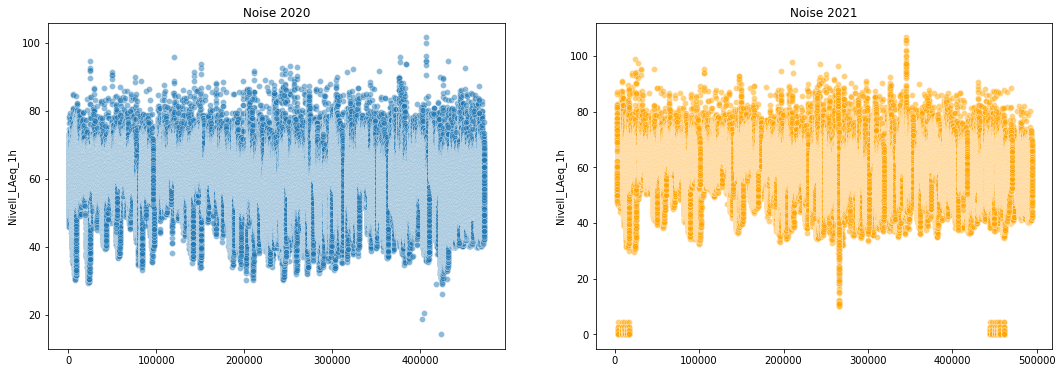

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot 2020
sns.scatterplot(noise_2020, alpha=0.5, ax=axs[0])
axs[0].set_title('Noise 2020')

# Boxplot 2021
sns.scatterplot(noise_2021, alpha=0.5, color='orange', ax=axs[1])
axs[1].set_title('Noise 2021')

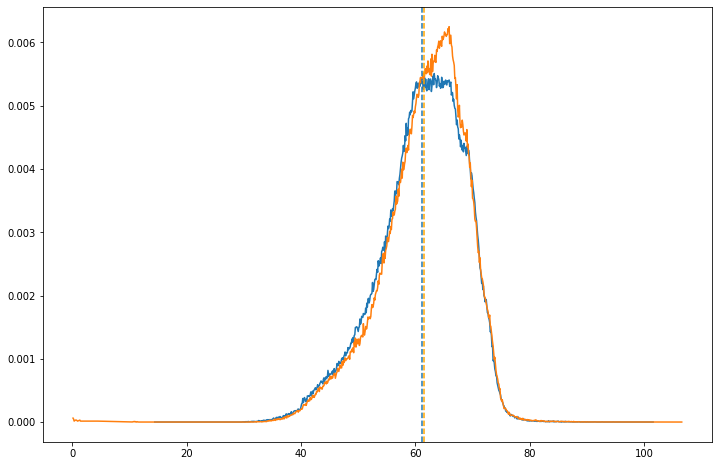

In [9]:
plt.figure(figsize=(12,8))
pmf_2020 = Pmf.from_seq(noise_2020)
pmf_2021 = Pmf.from_seq(noise_2021)

# Plot the figure
plt.plot(pmf_2020)
plt.plot(pmf_2021)
plt.axvline(np.mean(noise_2020), linestyle='--')
plt.axvline(np.mean(noise_2021), color='orange', linestyle='--')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Noise CDF')

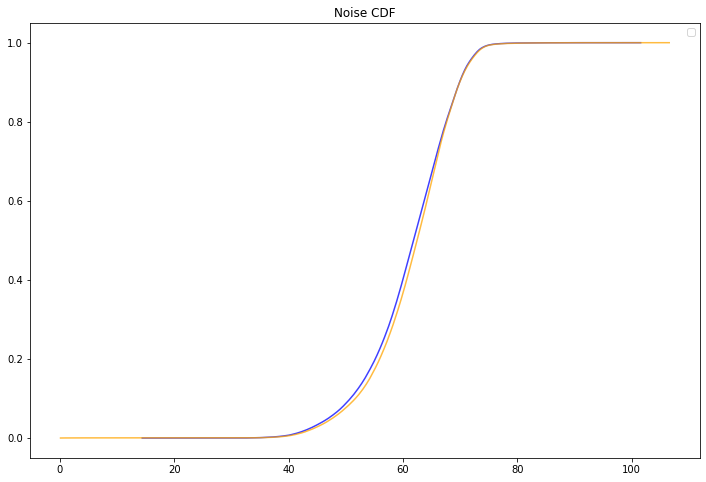

In [10]:
cdf_2020 = Cdf.from_seq(noise_2020)
cdf_2021 = Cdf.from_seq(noise_2021)

plt.figure(figsize=(12,8))
plt.plot(cdf_2020, color='Blue', alpha=0.75), 
plt.plot(cdf_2021, color='Orange', alpha=0.75)
plt.legend()
plt.title('Noise CDF')

## Mimimum Detectable Effect (MDE)

In [11]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm

# Initialize variables
i = 0  # This will track the fraction of the dataset allocated to the test group
data = {}  # To store results

# Loop to calculate MDE for splits ranging from 5% to 50% of the dataset
while i <= 0.25:
    i += 0.025  # Increment the fraction for each iteration
    mde_list = []  # To store MDE values for each iteration
    avg_list = []  # To store average values for the control group
    
    # Perform 30 simulations for each split to average the MDE
    for j in range(50):
        # Randomly split the dataset into test and control groups based on the current fraction
        test_df, control_df = train_test_split(noise_2020, test_size=i)
        
        # Define the parameters for the MDE calculation
        alpha = 0.025  # Significance level
        beta = 0.9    # Desired statistical power
        
        # Calculate standard deviations for both groups
        std_dev_test = np.std(test_df)
        std_dev_control = np.std(control_df)
        
        # Calculate sample sizes
        sample_size_control = len(control_df)
        sample_size_test = len(test_df)
        
        # Calculate critical values for the two-tailed test
        z_alpha = norm.ppf(1 - alpha/2)
        z_beta = norm.ppf(beta)
        
        # Calculate pooled standard deviation
        pooled_std_dev = np.sqrt(((sample_size_control - 1) * std_dev_control**2 + 
                                  (sample_size_test - 1) * std_dev_test**2) / 
                                 (sample_size_control + sample_size_test - 2))
        
        # Calculate the MDE
        mde = (z_alpha + z_beta) * pooled_std_dev * np.sqrt(2 / sample_size_control)
        
        # Append the MDE and average control group price to their respective lists
        mde_list.append(mde)
        avg = np.mean(control_df)
        avg_list.append(avg)
    
    # Calculate and store the average MDE, average price, and MDE percentage for the current split
    data[(round(i, 2))] = {'mde': round(np.mean(mde_list), 4),
                                  'avg': round(np.mean(avg_list), 4),
                                  'mde_%': round(np.mean(mde_list) / np.mean(avg_list) * 100, 2)}

In [12]:
data

{0.03: {'mde': 0.2591, 'avg': 61.1044, 'mde_%': 0.42},
 0.05: {'mde': 0.1832, 'avg': 61.0951, 'mde_%': 0.3},
 0.08: {'mde': 0.1496, 'avg': 61.1068, 'mde_%': 0.24},
 0.1: {'mde': 0.1296, 'avg': 61.1038, 'mde_%': 0.21},
 0.12: {'mde': 0.1159, 'avg': 61.1024, 'mde_%': 0.19},
 0.15: {'mde': 0.1058, 'avg': 61.1006, 'mde_%': 0.17},
 0.17: {'mde': 0.0979, 'avg': 61.1067, 'mde_%': 0.16},
 0.2: {'mde': 0.0916, 'avg': 61.1047, 'mde_%': 0.15},
 0.22: {'mde': 0.0864, 'avg': 61.1082, 'mde_%': 0.14},
 0.25: {'mde': 0.0819, 'avg': 61.1064, 'mde_%': 0.13},
 0.27: {'mde': 0.0781, 'avg': 61.1047, 'mde_%': 0.13}}

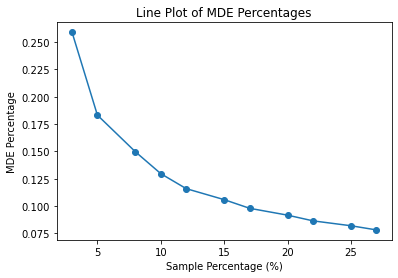

In [13]:
# Prepare data for plotting
percentage_split = [float(key)*100 for key in data.keys()]  # Convert keys to float and multiply by 100 to get percentages
mde_percentage_list_hist = [value['mde'] for value in data.values()]  # Extract MDE percentages

# Plotting
plt.plot(percentage_split, mde_percentage_list_hist, marker='o')  # 'o' adds markers to the line plot
plt.title('Line Plot of MDE Percentages')
plt.xlabel('Sample Percentage (%)')  # Updated to display counter percentage of the sample
plt.ylabel('MDE Percentage')

# Show the plot
plt.show()

## Outliers

Media de ruido en 2020: 61.10537945896509
Media de ruido en 2021: 61.58741159487094


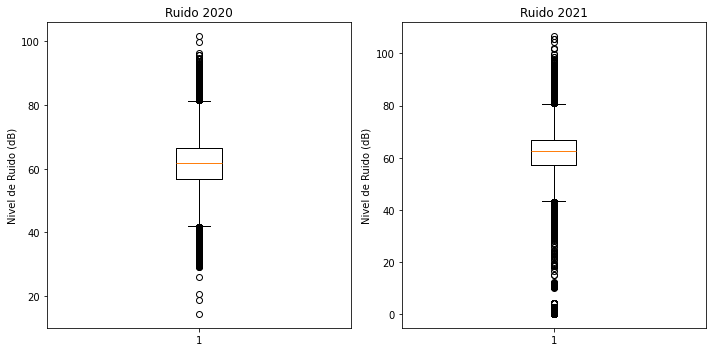

In [14]:
# Estadística descriptiva
print("Media de ruido en 2020:", np.mean(noise_2020))
print("Media de ruido en 2021:", np.mean(noise_2021))

# Boxplots para visualizar
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Boxplot 2020
axs[0].boxplot(noise_2020)
axs[0].set_title('Ruido 2020')
axs[0].set_ylabel('Nivel de Ruido (dB)')

# Boxplot 2021
axs[1].boxplot(noise_2021)
axs[1].set_title('Ruido 2021')
axs[1].set_ylabel('Nivel de Ruido (dB)')

plt.tight_layout()
plt.show()

In [15]:
def remove_outliers(data):
    q1, q3 = np.percentile(data, [25, 75])
    iqr = q3 - q1
    low_bound = q1 - 1.5 * iqr
    high_bound = q3 + 1.5 * iqr
    filtered_data = [x for x in data if low_bound <= x <= high_bound]
    return filtered_data

clean_noise_2020 = remove_outliers(noise_2020)
clean_noise_2021 = remove_outliers(noise_2021)

In [16]:
len(clean_noise_2020), len(noise_2020)

(810454, 822276)

Text(0.5, 1.0, 'Noise 2021')

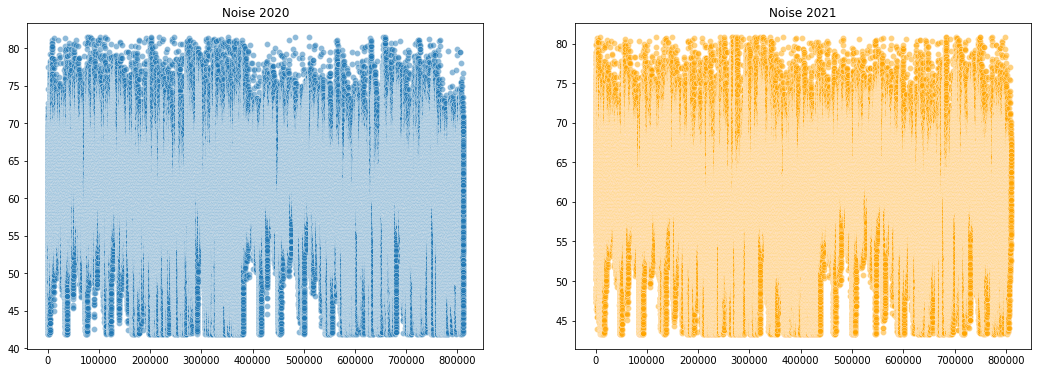

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot 2020
sns.scatterplot(clean_noise_2020, alpha=0.5, ax=axs[0])
axs[0].set_title('Noise 2020')

# Boxplot 2021
sns.scatterplot(clean_noise_2021, alpha=0.5, color='orange', ax=axs[1])
axs[1].set_title('Noise 2021')

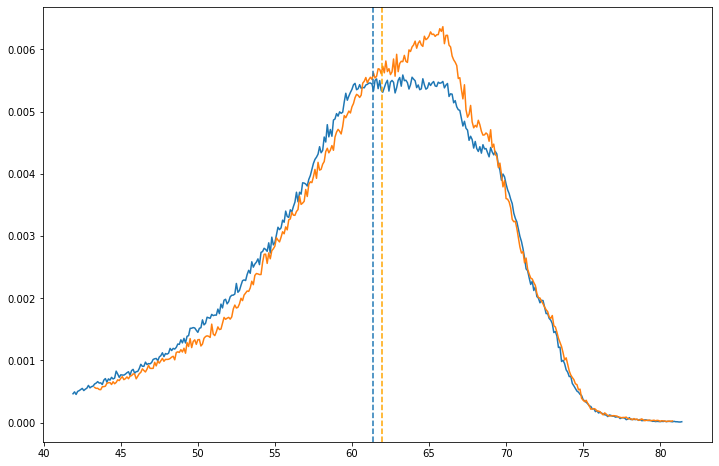

In [18]:
plt.figure(figsize=(12,8))
pmf_2020 = Pmf.from_seq(clean_noise_2020)
pmf_2021 = Pmf.from_seq(clean_noise_2021)

# Plot the figure
plt.plot(pmf_2020)
plt.plot(pmf_2021)
plt.axvline(np.mean(clean_noise_2020), linestyle='--')
plt.axvline(np.mean(clean_noise_2021), color='orange', linestyle='--')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Noise CDF')

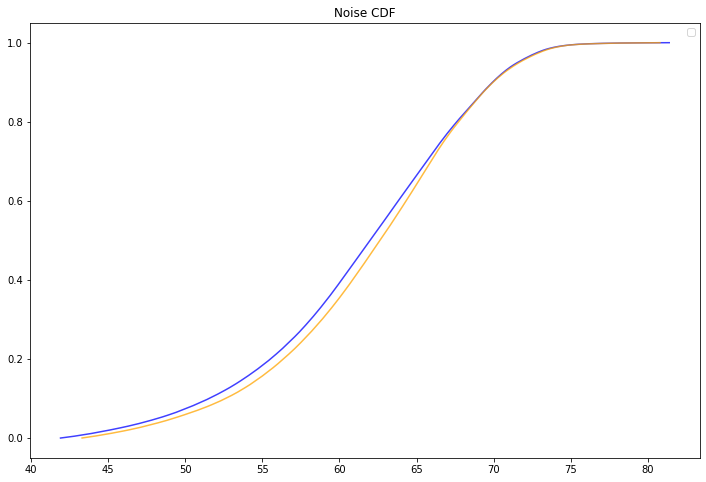

In [19]:
cdf_2020 = Cdf.from_seq(clean_noise_2020)
cdf_2021 = Cdf.from_seq(clean_noise_2021)

plt.figure(figsize=(12,8))
plt.plot(cdf_2020, color='Blue', alpha=0.75), 
plt.plot(cdf_2021, color='Orange', alpha=0.75)
plt.legend()
plt.title('Noise CDF')

## Noise by hour

In [20]:
import pandas as pd

filtered_df_2020['Hora'] = filtered_df_2020['Hora'].apply(lambda x: x[:-3]).astype(int)
filtered_df_2021['Hora'] = filtered_df_2021['Hora'].apply(lambda x: x[:-3]).astype(int)

# Agrupar por hora y calcular la media de ruido
noise_2020_by_hour = filtered_df_2020.groupby('Hora')['Nivell_LAeq_1h'].mean()
noise_2021_by_hour = filtered_df_2021.groupby('Hora')['Nivell_LAeq_1h'].mean()

# Calcular la diferencia promedio por hora
hourly_difference = noise_2021_by_hour - noise_2020_by_hour

# Identificar la franja horaria con el mayor cambio absoluto
max_change_hour = hourly_difference.abs().idxmax()
print(f"La franja horaria con el mayor cambio es: {max_change_hour}")
print(f"Diferencia promedio en esa franja: {hourly_difference[max_change_hour]:.2f} dB")

La franja horaria con el mayor cambio es: 16
Diferencia promedio en esa franja: 1.14 dB


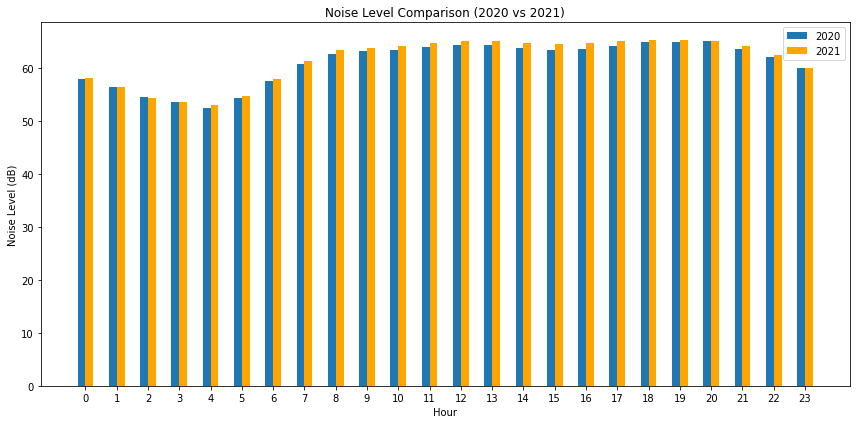

In [21]:
# Crear un rango para las posiciones
x = np.arange(len(noise_2020_by_hour.index))  # Índices de las horas

# Tamaño de las barras
bar_width = 0.25

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, noise_2020_by_hour, width=bar_width, label='2020')
plt.bar(x + bar_width/2, noise_2021_by_hour, color='orange', width=bar_width, label='2021')

# Etiquetas y título
plt.xlabel('Hour')
plt.ylabel('Noise Level (dB)')
plt.title('Noise Level Comparison (2020 vs 2021)')
plt.xticks(x, noise_2020_by_hour.index)  # Etiquetas de las horas
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [22]:
# Agrupar por hora y calcular la media de ruido
noise_2020_by_month = filtered_df_2020.groupby('Mes')['Nivell_LAeq_1h'].mean()
noise_2021_by_month = filtered_df_2021.groupby('Mes')['Nivell_LAeq_1h'].mean()

# Calcular la diferencia promedio por hora
monthly_difference = noise_2021_by_month - noise_2020_by_month

# Identificar la franja horaria con el mayor cambio absoluto
max_change_month = monthly_difference.abs().idxmax()
print(f"La franja horaria con el mayor cambio es: {max_change_month}")
print(f"Diferencia promedio en esa franja: {monthly_difference[max_change_month]:.2f} dB")

La franja horaria con el mayor cambio es: 1
Diferencia promedio en esa franja: -3.77 dB


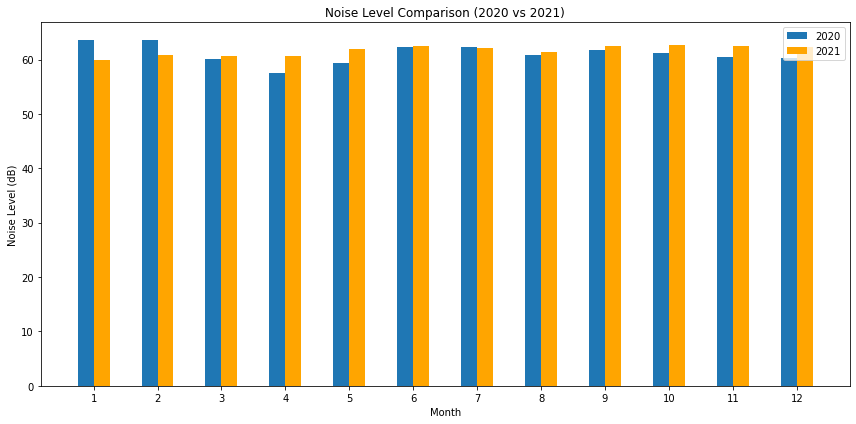

In [23]:
# Crear un rango para las posiciones
x = np.arange(len(noise_2020_by_month.index))  # Índices de las horas

# Tamaño de las barras
bar_width = 0.25

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, noise_2020_by_month, width=bar_width, label='2020')
plt.bar(x + bar_width/2, noise_2021_by_month, color='orange', width=bar_width, label='2021')

# Etiquetas y título
plt.xlabel('Month')
plt.ylabel('Noise Level (dB)')
plt.title('Noise Level Comparison (2020 vs 2021)')
plt.xticks(x, noise_2020_by_month.index)  # Etiquetas de las horas
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [24]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Load your data (example structure)
# Assume data is in a DataFrame with columns: 'sensor', 'month', 'day', 'noise_level'
# df = pd.read_csv('your_data.csv')

# ANOVA for months
anova_months = stats.f_oneway(*[filtered_df_2020[filtered_df_2020['Mes'] == m]['Nivell_LAeq_1h'] for m in filtered_df_2020['Mes'].unique()])
print("ANOVA for Months:", anova_months)

# ANOVA for days of the month
anova_days = stats.f_oneway(*[filtered_df_2020[filtered_df_2020['Dia'] == d]['Nivell_LAeq_1h'] for d in filtered_df_2020['Dia'].unique()])
print("ANOVA for Days:", anova_days)

# ANOVA for sensors
anova_sensors = stats.f_oneway(*[filtered_df_2020[filtered_df_2020['Id_Instal'] == s]['Nivell_LAeq_1h'] for s in filtered_df_2020['Id_Instal'].unique()])
print("ANOVA for Sensors:", anova_sensors)

# ANOVA for hours
anova_hours = stats.f_oneway(*[filtered_df_2020[filtered_df_2020['Hora'] == d]['Nivell_LAeq_1h'] for d in filtered_df_2020['Hora'].unique()])
print("ANOVA for Hours:", anova_hours)

"""
# Post-hoc analysis (if ANOVA is significant)
if anova_months.pvalue < 0.05:
    tukey_months = pairwise_tukeyhsd(filtered_df_2020['Nivell_LAeq_1h'], filtered_df_2020['Mes'])
    print(tukey_months)

if anova_days.pvalue < 0.05:
    tukey_days = pairwise_tukeyhsd(filtered_df_2020['Nivell_LAeq_1h'], filtered_df_2020['Dia'])
    print(tukey_days)
"""
if anova_sensors.pvalue < 0.05:
    tukey_sensors = pairwise_tukeyhsd(filtered_df_2020['Nivell_LAeq_1h'], filtered_df_2020['Hora'])
    print(tukey_sensors)

ANOVA for Months: F_onewayResult(statistic=3634.878731374982, pvalue=0.0)
ANOVA for Days: F_onewayResult(statistic=24.882349149199612, pvalue=1.1429536258024328e-137)
ANOVA for Sensors: F_onewayResult(statistic=4391.439622985567, pvalue=0.0)
ANOVA for Hours: F_onewayResult(statistic=14791.240463414162, pvalue=0.0)
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -1.3781    0.0 -1.5523 -1.2039   True
     0      2  -3.4079    0.0 -3.5822 -3.2335   True
     0      3   -4.303    0.0 -4.4772 -4.1289   True
     0      4  -5.3353    0.0 -5.5095 -5.1612   True
     0      5  -3.5127    0.0  -3.687 -3.3385   True
     0      6   -0.387    0.0 -0.5612 -0.2128   True
     0      7   2.9386    0.0  2.7643  3.1129   True
     0      8   4.8463    0.0  4.6721  5.0206   True
     0      9   5.2712    0.0  5.0971  5.4454   True
     0     10   5.6007    0.0  5.4266  5.7747   

## Shapiro test for Normal Distribution

In [25]:
from scipy.stats import shapiro, kstest

# Example: Shapiro-Wilk test for normality
stat_2020, p_2020 = shapiro(clean_noise_2020)
stat_2021, p_2021 = shapiro(clean_noise_2021)

for p in [p_2020, p_2021]:
    if p > 0.05:
        print("Data is normally distributed.")
    else:
        print("Data is not normally distributed.")


Data is not normally distributed.
Data is not normally distributed.


## A/B Testing

In [26]:
from scipy.stats import ttest_ind

# Perform a two-tailed t-test
t_stat, p_value= ttest_ind(clean_noise_2020, clean_noise_2021, equal_var=False, alternative='less')

# Display the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -51.652680849200536
P-value: 0.0


In [27]:
# A/B Testing Function - Quick Solution
def AB_Test(groupA, groupB):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(clean_noise_2020, clean_noise_2021)

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0,A/B groups are not similar!
